Mario Pasquato - MSCA-IF fellow, Université de Montréal - mario.pasquato@gmail.com

# eXplainable Artificial Intelligence (XAI)

## Goals of this unit

The supervised classification methods that we saw in the previous units are often perceived as black boxes. And they frequently are! Can we do something about this? There are at least [two approaches](https://christophm.github.io/interpretable-ml-book/taxonomy-of-interpretability-methods.html):

* Use only natively interpretable models. For example, the coefficients of logistic regression (which we saw last time) are immediately interpretable in terms of predicting a higher (or lower) probability of being a member of a given class.

* Use post-hoc interpretability tools. These are attempts at peering into the black box to figure out how our model thinks

![black box](blackbox.jpeg)

Of course neither approach is perfect. Intrinsically interpretable models may perform worse than black boxes because they tend to be too simple, as is the case for the one we saw in detail (logistic regression). Black boxes are... well, black boxes.


There is plenty of room for creativity in exploring new solutions. This is badly needed because in science and in astronomy in particular we want to understand what is going on rather than trusting a black box. You can find a survey of XAI techniques for tabular data [here](https://ieeexplore.ieee.org/abstract/document/9551946) and of course take a look at the book linked above. The author of the survey was my neighbor in Abu Dhabi and she also has a nice video covering these techniques [here](https://www.youtube.com/watch?v=G3mSAdq2o9Y).

In [3]:
%matplotlib inline
from scipy.ndimage.filters import uniform_filter1d as uf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rrc_stars = os.listdir('rrc')
deltascuti_stars = os.listdir('ds')
p=30

def scale_star_and_shift_phase(star):
    scaled_star = star.sort_values(by="Phase", axis=0)
    MEDIAN = scaled_star["Mag"].median()
    MAD = scaled_star["Mag"].mad()
    scaled_star["Mag"] = (scaled_star["Mag"] - MEDIAN)/MAD
    maximum = np.argmax(uf(scaled_star["Mag"],3))
    scaled_star["Phase"] = scaled_star["Phase"] - scaled_star.iloc[maximum, 2] 
    scaled_star["Phase"] += (scaled_star["Phase"] < 0)
    scaled_star = scaled_star.sort_values(by="Phase", axis=0)
    return(scaled_star)

def interpolate_star(star, p):
    smooth_star = star.iloc[:p,:].copy()
    smooth_star["Phase"] = (1.0+np.arange(p))/p
    smooth_star["Mag"] = np.nan 
    smooth_star["ID"] = "interpolated" 
    star = pd.concat((star, smooth_star), axis=0).sort_values(by="Phase", axis=0)
    interpolated_star = star.interpolate()
    return interpolated_star

def featurize_star(star, p):
    interpolated_star = interpolate_star(scale_star_and_shift_phase(star), p)
    return interpolated_star[interpolated_star["ID"] == 'interpolated']["Mag"].to_numpy()

n = len(rrc_stars) + len(deltascuti_stars)
labels = np.zeros(n)
labels[:len(rrc_stars)]=1

data = np.zeros([n,p+1])
data[:,p] = labels
for i in range(len(rrc_stars)):
    data[i,:p] = featurize_star(pd.read_csv(os.path.join("rrc/", rrc_stars[i])), p)
for i in range(len(deltascuti_stars)):
    data[len(rrc_stars)+ i,:p] = featurize_star(pd.read_csv(os.path.join("ds/", deltascuti_stars[i])), p)
    
data = pd.DataFrame(data, columns = [*['f' + str(i) for i in range(p)], 'label'])
data.head()

f0        f1        f2        f3        f4        f5        f6  \
0  1.814176  1.751007  1.615440  1.734919  1.283031  0.536114  0.426336   
1  0.886162  0.534592 -1.210435 -0.782724 -1.746220 -1.744328 -1.782422   
2  1.323247  0.963173  0.687242  0.378406 -0.059229 -0.592758 -1.077870   
3  1.077887  0.630309 -0.293733 -1.257698 -0.779286 -0.909762 -1.074317   
4  0.763774  0.348126 -0.329804 -0.636195 -1.167546 -1.797973 -1.538744   

         f7        f8        f9       f10       f11       f12       f13  \
0  0.061277 -0.633826 -0.500152 -0.608748 -0.217900 -0.631460 -0.121844   
1 -1.505034 -1.347030 -1.189025 -0.822842 -1.230314 -1.518698 -1.831074   
2 -0.850357 -0.837195 -1.020052 -1.303504 -1.487771 -1.648535 -1.334059   
3 -0.877629 -0.868866 -1.324558 -0.646213 -0.209346 -0.536834 -0.484254   
4 -1.798312 -1.869227 -1.794240 -1.742666 -1.655465 -1.552995 -1.241853   

        f14       f15       f16       f17       f18       f19       f20  \
0 -0.178626 -0.281070 -0.285092  0.034069  0.219793  0.581540  0.858824   
1 -2.143451 -1.587096 -1.028862  0.034229 -0.334618 -0.920490 -0.074116   
2 -1.317136 -0.811811 -0.878091 -1.087272 -0.808990 -0.565024 -0.284392   
3 -0.365138 -0.141836  0.191495  0.528720  0.538781  0.771496  0.960719   
4 -1.119025 -1.107489 -0.861493 -0.592086  0.093648  0.184242  0.398682   

        f21       f22       f23       f24       f25       f26       f27  \
0  1.040998  1.601955  1.502113 -0.420658 -0.045899  1.688310  1.764492   
1 -0.385796  0.080411  0.272465  0.616910  0.856014  0.552064  1.369848   
2  0.110466  0.197899  0.734249  0.856938  0.701344  0.900654  0.857878   
3  1.151564  1.427122  1.193109  1.338515  1.840945  1.489114  1.542992   
4  0.616176  0.607354  1.057272  0.954802  1.000269  0.911710  1.057950   

        f28       f29  label  
0  2.058574  2.109678    1.0  
1  2.125835  2.305493    1.0  
2  1.464268  1.496703    1.0  
3  1.919814  1.382007    1.0  
4  1.144812  1.163813    1.0

Let's train a black box classifier on this data. Note that this can be anything, maybe not even a machine learning classifier. It could be a proprietary software package or even a human. All it has to do is predicte a label given the input features.

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


X = data.iloc[:,:p].to_numpy()
y = data.iloc[:,p].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=888)

black_box = SVC(gamma='auto', probability = True, C=10)
black_box.fit(X_train, y_train)
test_predictions = black_box.predict(X_test)

confusion_matrix(y_test, test_predictions)

array([[36, 12],
       [17, 35]])

In [5]:
accuracy_score(y_test, test_predictions)

0.71

## Permutation feature importance

A question we can answer relatively easily even without access to the black box is which features are important.
One way to do this is to permute (over the rows) one feature at a time, while keeping the other constant. That feature essentially becomes random. Then we measure how the performance of the classifier drops. The idea is that performance will drop more if a feature is more important.


This of course does not fully answer the original question but it is a start.

In [6]:
from sklearn.inspection import permutation_importance
repeats = 100
imp = permutation_importance(black_box, X_test, y_test, n_repeats=100, random_state=4, scoring='accuracy')

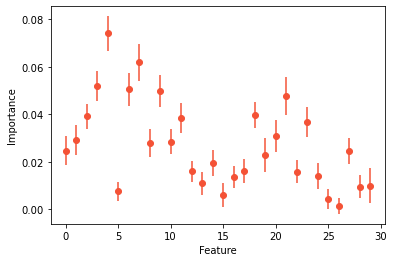

In [7]:
three_sigma_error = 3*imp["importances_std"]/np.sqrt(repeats-1)
gentle_coral = "#F45236"
plt.errorbar(np.arange(p), imp["importances_mean"], yerr=three_sigma_error, xerr=None, fmt='o', color = gentle_coral)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

We can plot a featurized light curve (so essentially plot features as a function of phase) and show with color what the importance of each feature is.

Text(0, 0.5, 'Mag')

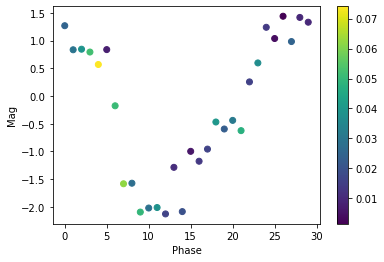

In [8]:
plt.scatter(np.arange(p), X_test[0,:], c = imp["importances_mean"])
plt.colorbar()
plt.xlabel("Phase")
plt.ylabel("Mag")

Note that this does not show us how important a feature really is. It shows us how important it is to a given classifier, or better yet to a combination of classifier and performance metric.
Maybe the features that matter to achieve good precision are not the same that matter to achieve good recall.

Moreover the features may interact, i.e. the probability of being class $A$ depends on the joint distribution of two or more features rather than just on the value of one feature while the others are kept constant. This may be [an issue](https://scikit-learn.org/stable/modules/permutation_importance.html#misleading-values-on-strongly-correlated-features) for our rather simplistic approach. 

## Individual Conditional Expectation (ICE)

How does our prediction of the probability of an instance being in a given class change if we change the value of one feature while keeping the others fixed? The answer to this is the individual conditional expectation plot, below.

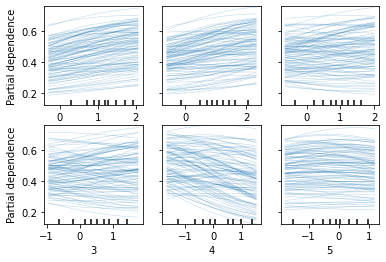

In [9]:
from sklearn.inspection import PartialDependenceDisplay as PDD
PDD.from_estimator(black_box, X_test, range(6), kind='individual')
plt.show()

We can also look at the mean of all these curves to get a partial dependence plot. This gives us a general idea of how prediction depends on a given feature in the aggregate, for all instances.

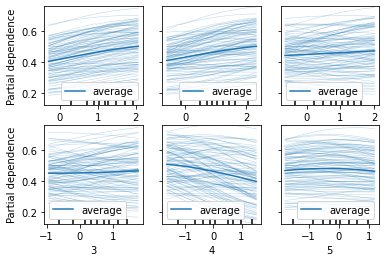

In [10]:
PDD.from_estimator(black_box, X_test, range(6), kind='both')
plt.show()

Note how for feature $4$ some curves cross each other, while others are parallel. When the curves are not parallel it means that the way predictions change when only one feature changes is instance-dependent. For a given star, increasing a feature has a different effect than for another star.

If we believe that our features encode all the relevant aspects of our object, then the difference in behavior must be due to differences in other features. So the features interact. Let's have a look at two features varied together then.

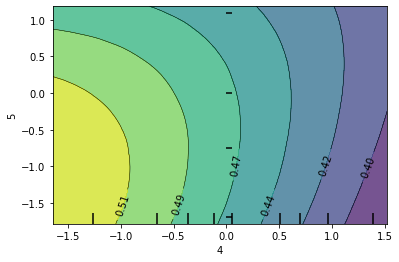

In [11]:
PDD.from_estimator(black_box, X_test, [[4,5],])
plt.show()

It looks like feature $5$ is almost irrelevant if it's below $\approx 0$ but changes the way modifying feature $4$ affects predicted probability when it's $>0$. The features interact.

Remember that permutation feature importance told us that feature $5$ was unimportant, while feature $4$ is very important. So it did not tell us the whole story.

In [12]:
pd.DataFrame(X_test[:,4:6]).corr()

0         1
0  1.000000  0.718852
1  0.718852  1.000000

In fact, feature $4$ and feature $5$ are correlated. If we permute feature $5$ while feature $4$ is kept constant then good accuracy can still be achieved by relying on feature $4$, so it seems like feature $5$ is unimportant.
Why is feature $4$ still considered very important though?

## Counterfactuals

There are many ways to define counterfactuals, and even dedicated XAI libraries such as [alibi](https://docs.seldon.io/projects/alibi/en/stable/methods/CF.html) provide several.
In general the idea is to find, for a given instance which got classified in a given way, a nearby instance that would be classified differently. This suggests how to change a data point to change the classification predicted by the model.

Here I am just finding the nearest data point that is classified differently.

1.0
0.0


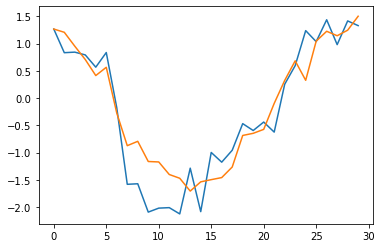

In [34]:
from numpy.linalg import norm #as usual, use the norm you like. Often L1 norm in counterfactuals...

def find_counterfactual(X, x, predicted_classes, desired_class):
    distances = np.array([norm(X[i,:]-x) for i in range(X.shape[0])])
    distances[predicted_classes != desired_class] = np.max(distances) + 1.0
    i_cf = np.argmin(distances)
    return X[i_cf,:]

print(y_test[0]) #the first instance was a RRc
print(test_predictions[0]) #misclassified as an DS

counterfactual = find_counterfactual(X_test, X_test[0,:], test_predictions, 1)

plt.plot(np.arange(p), X_test[0,:])
plt.plot(np.arange(p), counterfactual)
plt.show()

Orange curve represent the nearest star that was classified as an RRc. This suggests that if we change features $6$ to $12$ we may end up correctly classifying the star.

1.0
1.0


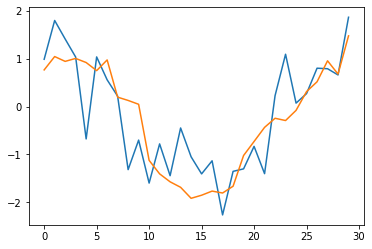

In [38]:
print(y_test[19]) #the twentieth instance was a RRc
print(test_predictions[19]) #correctly classified as a RRc

counterfactual = find_counterfactual(X_test, X_test[19,:], test_predictions, 0)

plt.plot(np.arange(p), X_test[19,:])
plt.plot(np.arange(p), counterfactual)
plt.show()

The counterfactual is the nearest star classified as a DS.